In [1]:
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.decomposition import TruncatedSVD, IncrementalPCA
from scipy.stats import chi2_contingency
from nltk.probability import FreqDist
from collections import defaultdict
from clpsych.store import Store
from clpsych.helpers import load_tokens

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import pandas as pd
import numpy as np
import codecs
import spacy
import glob

In [3]:
nlp = spacy.load('en')

def get_distribution(dataframe, key='title'):
    words = []
    for row in dataframe[key].apply(lambda x: x.split()).ravel():
        words.extend(row)
    return FreqDist(words)

def aggregate_posts(posts_with_users):
    users = defaultdict(list)
    labeled_users, bows = [], []

    for i, post_id, user_id in posts_with_users.itertuples():
        users[user_id].append(i)

    for user, posts in users.items():
        bows.append(np.sum(vocab[posts], axis=0))
        labeled_users.append(user > 0)

    bows = np.vstack(bows)
    labeled_users = np.array(labeled_users)
    
    return bows, labeled_users

def vectorize_text(text):
    tokens = [
        nlp.vocab[token.decode('utf-8')].vector 
        for token in text.strip().split() 
        if token.decode('utf-8') in nlp.vocab
    ]
    
    #print tokens
    
    return np.sum(tokens, axis=0) / (1. * len(tokens))

In [4]:
train_classes = pd.DataFrame.from_csv('data/classes/train_classes.txt')
dev_classes = pd.DataFrame.from_csv('data/classes/dev_classes.txt')
#sample_classes = pd.DataFrame.from_csv('data/classes/sample_classes.txt')

In [5]:
df = load_tokens(mask='data/tokens/tokens?.txt')

sent1 = pd.DataFrame.from_csv('data/features/sentiment_all.csv')
read1 = pd.DataFrame.from_csv('data/features/readability1.csv')
read2 = pd.DataFrame.from_csv('data/features/readability2.csv')
times = pd.DataFrame.from_csv('data/features/timing.csv')

df = df\
    .merge(sent1[['post_id', 'user_id', 'text_sentiment', 'title_sentiment']], on='post_id')\
    .merge(read1[['post_id', 'text_smog', 'text_readability', 'title_readability']], on='post_id')\
    .merge(read2[['post_id', 'title_smog']], on='post_id')\
    .merge(times[['post_id', 'night_post', 'time_since_last_post']])

In [6]:
# clear unused variables
%reset_selective sent1
%reset_selective read1
%reset_selective read2
%reset_selective times

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [6]:
labeled_docs = df.merge(train_classes, on='post_id').replace(np.nan, '', regex=True)
test_docs = df.merge(dev_classes, on='post_id').replace(np.nan, '', regex=True)

In [10]:
labeled_docs['text_features'] = labeled_docs[['title', 'doc']].apply(lambda x: ' '.join(x), axis=1)
test_docs['text_features'] = test_docs[['title', 'doc']].apply(lambda x: ' '.join(x), axis=1)

In [7]:
# clear out the big dataframe -- now we only need the subsets
%reset_selective df

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Classification

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(),
    stop_words='english', 
    decode_error='ignore', 
    min_df=40
)

transformer = TfidfTransformer()

In [12]:
vectorizer.fit(labeled_docs.text_features)
vocab = vectorizer.transform(labeled_docs.text_features)
transformer.fit(vocab)
vocab = transformer.transform(vocab)
test = transformer.transform(vectorizer.transform(test_docs.text_features))
#test = vectorizer.transform(test_docs.title)

In [13]:
svd = TruncatedSVD(n_components=300, algorithm='arpack')
svd.fit(vocab)

TruncatedSVD(algorithm='arpack', n_components=400, n_iter=5,
       random_state=None, tol=0.0)

In [14]:
vocab = svd.transform(vocab)
test = svd.transform(test)

In [16]:
%reset_selective svd
%reset_selective vectorizer
%reset_selective transformer

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Using GloVe Instead of LDA

In [36]:
vocab = np.zeros((len(labeled_docs), 300))
for ix, post_id, tokens in labeled_docs[['post_id', 'title']].itertuples():
    vocab[ix, :] = vectorize_text(tokens)
    if ix % 100000 == 0: print ix

0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [35]:
test = np.zeros((len(test_docs), 300))
for ix, post_id, tokens in test_docs[['post_id', 'title']].itertuples():
    test[ix, :] = vectorize_text(tokens)
    if ix % 100000 == 0: print ix

0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


100000
200000


In [33]:
vocab.shape

(1721125, 300)

## CLASSIFICATION

In [15]:
features = ['text_sentiment', 'title_sentiment', 'text_readability', 'title_readability', 'text_smog', 'title_smog']

X_train = labeled_docs[features].as_matrix()
y_train = labeled_docs['class'].as_matrix().astype('float')

X_test = test_docs[features].as_matrix()
y_test = test_docs['class'].as_matrix().astype('float')

In [16]:
# clear out some additional memory
%reset_selective labeled_docs
%reset_selective test_docs

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


In [17]:
# start with the smaller matri
X_test = np.hstack((test, X_test))
#%reset_selective test
# hstack and then immediately try and reclaim space
X_train = np.hstack((vocab, X_train))
#%reset_selective vocab

# X_test = scipy.sparse.hstack((test, X_test))
# X_train = scipy.sparse.hstack((vocab, X_train))

In [48]:
X_train[np.isnan(X_train)] = 0.
X_test[np.isnan(X_test)] = 0.

### Classify Each User

In [18]:
#clf = MultinomialNB()
#clf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=6)
clf = LogisticRegression()
#clf = AdaBoostClassifier()

In [19]:
#clf.fit(train_bows, train_labels)
clf.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
labels = clf.predict_proba(X_test)

In [21]:
accuracy_score(y_test, np.argmax(labels, axis=1))

0.73210045750246122

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, labels[:, 1])

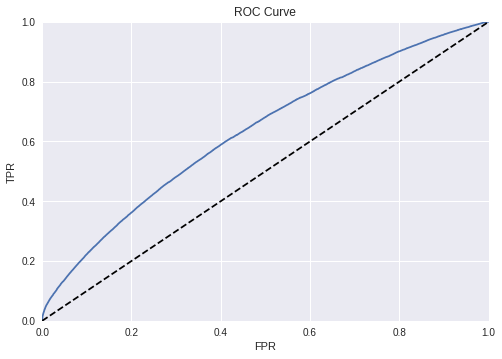

In [23]:
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')

In [24]:
roc_auc_score(y_test, labels[:, 1])

0.63239503296317978

### Aggregate the Posts by User

In [25]:
#posts_with_users = labeled_docs.merge(data[['post_id', 'user_id']], on='post_id')[['post_id', 'user_id']]
#train_bows, train_labels = aggregate_posts(labeled_docs)

In [26]:
#test_posts_with_users = test_docs.merge(data[['post_id', 'user_id']], on='post_id')[['post_id', 'user_id']]
#test_bows, test_labels = aggregate_posts(test_docs)

# Statistical Tests

In [27]:
# positives = labeled_docs[labeled_docs['class'] == False]
# controls = labeled_docs[labeled_docs['class'] == True]

# positive_dist = get_distribution(positives, key='title')
# controls_dist = get_distribution(controls, key='title')

In [28]:
# values = []
# for word, count in positive_dist.most_common():
#     if count < 50 or 1. * count / len(positives) > 0.4: continue
        
#     obs = np.array([
#         [positive_dist[word], positive_dist.N()-positive_dist[word]],
#         [controls_dist[word], controls_dist.N()-controls_dist[word]]
#     ])
#     g, p, _, _ = chi2_contingency(obs, lambda_='log-likelihood')
#     values.append((word, g))

# values = sorted(values, key=lambda x: x[1], reverse=True)